CUDA available:  True
CUDA device count:  1
CUDA current device:  0
CUDA device name:  NVIDIA GeForce RTX 3070 Ti
CUDA device capability:  (8, 6)
CUDA device memory:  8.589410304
Number of training images: 5631
Number of validation images: 2371
Number of parameters: 4463363


Epoch 1/6:   0%|          | 0/2816 [00:00<?, ?it/s, loss=1.84e+4, psnr=4.28]

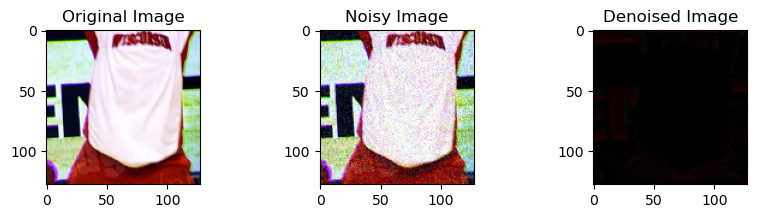

Epoch 1/6:  36%|███▌      | 1000/2816 [02:41<04:55,  6.16it/s, loss=178, psnr=26.6]  

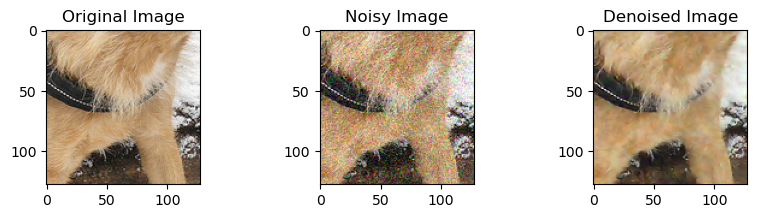

Epoch 1/6:  71%|███████   | 2000/2816 [05:17<02:03,  6.60it/s, loss=133, psnr=27.1]

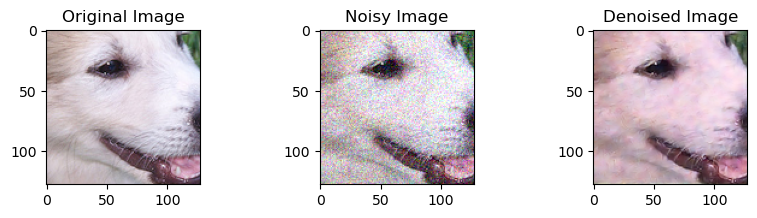

Epoch 1/6: 100%|██████████| 2816/2816 [07:21<00:00,  6.38it/s, loss=120, psnr=28]  


Epoch [1/6], Train Loss: 120.03570864214139, Train PSNR: 28.015277194976807
Epoch [1/6], Validation Loss: 85.28279976740254, Validation PSNR: 27.92394395828247


Epoch 2/6:   0%|          | 0/2816 [00:00<?, ?it/s, loss=92.4, psnr=27.3]

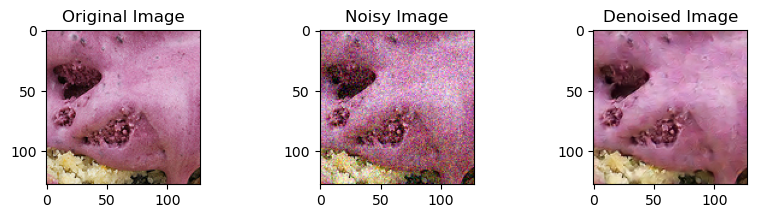

Epoch 2/6:  36%|███▌      | 1000/2816 [02:39<04:44,  6.37it/s, loss=83.4, psnr=28.3]

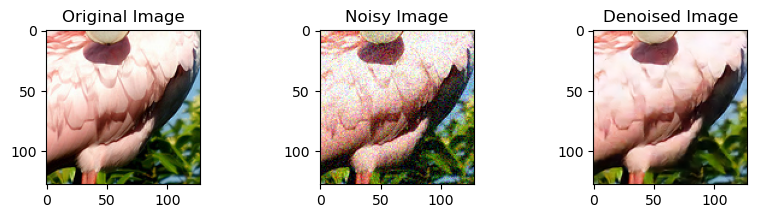

Epoch 2/6:  71%|███████   | 2000/2816 [05:15<02:07,  6.38it/s, loss=82.9, psnr=28.7]

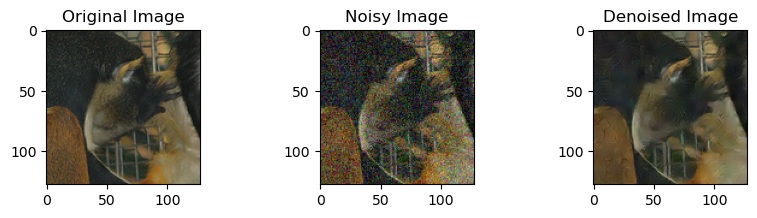

Epoch 2/6: 100%|██████████| 2816/2816 [07:24<00:00,  6.34it/s, loss=80.6, psnr=28.6]


Epoch [2/6], Train Loss: 80.56522378054532, Train PSNR: 28.648790493011475
Epoch [2/6], Validation Loss: 71.86019198367809, Validation PSNR: 28.69373363494873


Epoch 3/6:   0%|          | 0/2816 [00:00<?, ?it/s, loss=66.3, psnr=28.7]

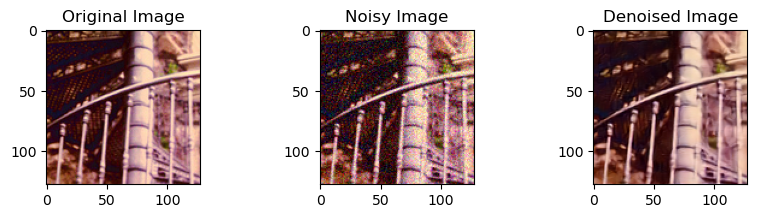

Epoch 3/6:  36%|███▌      | 1000/2816 [02:35<04:45,  6.35it/s, loss=87.6, psnr=27.7]

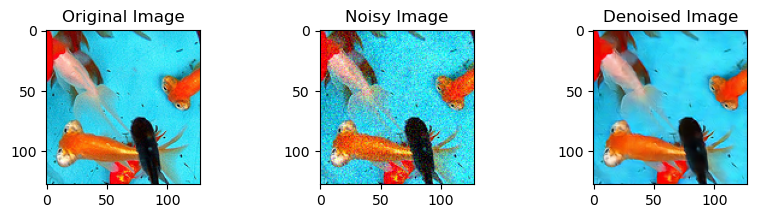

Epoch 3/6:  71%|███████   | 2000/2816 [05:10<02:05,  6.51it/s, loss=79.6, psnr=28.4]

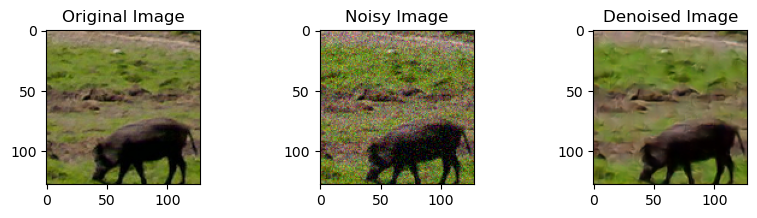

Epoch 3/6: 100%|██████████| 2816/2816 [07:18<00:00,  6.43it/s, loss=77.3, psnr=28.7]


Epoch [3/6], Train Loss: 77.313140749254, Train PSNR: 28.70016513824463
Epoch [3/6], Validation Loss: 72.80797614214995, Validation PSNR: 28.65853563308716


Epoch 4/6:   0%|          | 0/2816 [00:00<?, ?it/s, loss=94.3, psnr=27.2]

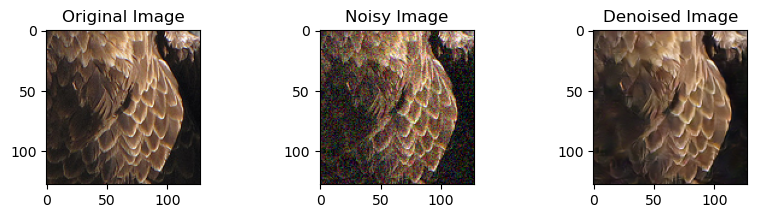

Epoch 4/6:   8%|▊         | 214/2816 [00:33<06:51,  6.32it/s, loss=2.75e+3, psnr=15.9]


KeyboardInterrupt: 

In [1]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.nn.modules.loss import _Loss
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Residual Dense Block
class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate=32):
        super(ResidualDenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, growth_rate, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_channels + growth_rate, growth_rate, 3, 1, 1)
        self.conv3 = nn.Conv2d(in_channels + 2 * growth_rate, growth_rate, 3, 1, 1)
        self.conv4 = nn.Conv2d(in_channels + 3 * growth_rate, growth_rate, 3, 1, 1)
        self.conv5 = nn.Conv2d(in_channels + 4 * growth_rate, in_channels, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        out1 = self.lrelu(self.conv1(x))
        out2 = self.lrelu(self.conv2(torch.cat((x, out1), 1)))
        out3 = self.lrelu(self.conv3(torch.cat((x, out1, out2), 1)))
        out4 = self.lrelu(self.conv4(torch.cat((x, out1, out2, out3), 1)))
        out5 = self.conv5(torch.cat((x, out1, out2, out3, out4), 1))
        return out5 * 0.2 + x

# Residual Dense Network (RDN)
class RDN(nn.Module):
    def __init__(self, in_channels, num_blocks=16, growth_rate=32):
        super(RDN, self).__init__()
        self.initial_conv = nn.Conv2d(in_channels, growth_rate, 3, 1, 1)
        self.rdbs = nn.ModuleList([ResidualDenseBlock(growth_rate) for _ in range(num_blocks)])
        self.conv_after_rdbs = nn.Conv2d(num_blocks * growth_rate, growth_rate, 1, 1, 0)
        self.final_conv = nn.Conv2d(growth_rate, in_channels, 3, 1, 1)

    def forward(self, x):
        out = self.initial_conv(x)
        concat_rdbs = torch.cat([rdb(out) for rdb in self.rdbs], 1)
        out = self.conv_after_rdbs(concat_rdbs)
        out = self.final_conv(out)
        return out
# Custom loss function
class SumSquaredError(_Loss):
    def __init__(self, reduction='sum'):
        super(SumSquaredError, self).__init__(reduction=reduction)

    def forward(self, input, target):
        return torch.nn.functional.mse_loss(input, target, reduction=self.reduction).div_(2)

# Dataset class for image loading
class ImageDataset(Dataset):
    def __init__(self, image_dir):
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.startswith(('clean_', 'noisy_'))]
        self.image_paths.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0].split('_')[-1]))
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths) // 2

    def __getitem__(self, idx):
        clean_image_path = self.image_paths[idx * 2]
        noisy_image_path = self.image_paths[idx * 2 + 1]
        clean_image = Image.open(clean_image_path).convert('RGB')
        noisy_image = Image.open(noisy_image_path).convert('RGB')
        clean_image = self.transform(clean_image)
        noisy_image = self.transform(noisy_image)
        return noisy_image, clean_image

# PSNR calculation
def PSNR(clean_image, noisy_image, denoised_image):
    mse_noisy = torch.mean((clean_image - noisy_image) ** 2)
    mse_denoised = torch.mean((clean_image - denoised_image) ** 2)
    psnr_noisy = 20 * torch.log10(1.0 / torch.sqrt(mse_noisy))
    psnr_denoised = 20 * torch.log10(1.0 / torch.sqrt(mse_denoised))
    return psnr_noisy.item(), psnr_denoised.item()

# Training function
def train_dncnn(model, train_loader, val_loader, num_epochs=6, learning_rate=1e-3):
    criterion = SumSquaredError()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    train_losses = []
    val_losses = []
    train_psnrs = []
    val_psnrs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_psnr = []
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, (noisy_images, clean_images) in progress_bar:
            noisy_images, clean_images = noisy_images.cuda(non_blocking=True), clean_images.cuda(non_blocking=True)
            optimizer.zero_grad()
            outputs = model(noisy_images)
            outputs = torch.clamp(outputs, 0, 1)
            loss = criterion(outputs, clean_images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            psnr_noisy, psnr_denoised = PSNR(clean_images, noisy_images, outputs)
            train_psnr.append(psnr_denoised)
            progress_bar.set_postfix(loss=running_loss / (i + 1), psnr=np.mean(train_psnr[-100:]))  # Average PSNR on last 100 values

            # tout les 1000 étapes on affiche une image 
            if i % 1000 == 0:
                noisy_image_np = noisy_images[0].cpu().numpy().transpose(1, 2, 0) * 255.0
                clean_image_np = clean_images[0].cpu().numpy().transpose(1, 2, 0) * 255.0
                denoised_image_np = outputs[0].detach().cpu().numpy().transpose(1, 2, 0) * 255.0

                plt.figure(figsize=(10, 2))
                plt.subplot(1, 3, 1)
                plt.imshow(clean_image_np.astype(np.uint8))
                plt.title('Original Image')
                plt.subplot(1, 3, 2)
                plt.imshow(noisy_image_np.astype(np.uint8))
                plt.title('Noisy Image')
                plt.subplot(1, 3, 3)
                plt.imshow(denoised_image_np.astype(np.uint8))
                plt.title('Denoised Image')
                plt.show()
                

        scheduler.step()
        avg_train_loss = running_loss / len(train_loader)
        avg_train_psnr = np.mean(train_psnr[-100:])  # Average PSNR on last 100 values
        train_losses.append(avg_train_loss)
        train_psnrs.append(avg_train_psnr)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss}, Train PSNR: {avg_train_psnr}")

        model.eval()
        val_loss = 0.0
        val_psnr = []
        with torch.no_grad():
            for noisy_images, clean_images in val_loader:
                noisy_images, clean_images = noisy_images.cuda(non_blocking=True), clean_images.cuda(non_blocking=True)
                outputs = model(noisy_images)
                outputs = torch.clamp(outputs, 0, 1)
                loss = criterion(outputs, clean_images)
                val_loss += loss.item()
                psnr_noisy, psnr_denoised = PSNR(clean_images, noisy_images, outputs)
                val_psnr.append(psnr_denoised)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_psnr = np.mean(val_psnr[-100:])  # Average PSNR on last 100 values
        val_losses.append(avg_val_loss)
        val_psnrs.append(avg_val_psnr)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}, Validation PSNR: {avg_val_psnr}")

    # Plot loss and PSNR
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Evolution')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_psnrs, label='Train PSNR')
    plt.plot(val_psnrs, label='Validation PSNR')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.title('PSNR Evolution')

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_psnrs, val_psnrs

# Denoising function
def denoise_image(model, noisy_image):
    model.eval()
    with torch.no_grad():
        noisy_image = noisy_image.unsqueeze(0).cuda()
        denoised_image = model(noisy_image)
        denoised_image = torch.clamp(denoised_image, 0, 1)  # Clamp output values to range [0, 1]
        denoised_image = denoised_image.squeeze().cpu().numpy()
    return denoised_image

# Example usage
if __name__ == "__main__":
    torch.cuda.empty_cache()

    if not torch.cuda.is_available():
        raise SystemError("CUDA device is not available. Training requires a GPU.")

    print("CUDA available: ", torch.cuda.is_available())
    print("CUDA device count: ", torch.cuda.device_count())
    print("CUDA current device: ", torch.cuda.current_device())
    print("CUDA device name: ", torch.cuda.get_device_name())
    print("CUDA device capability: ", torch.cuda.get_device_capability())
    print("CUDA device memory: ", torch.cuda.get_device_properties(0).total_memory / 1e9)

    image_dir = 'C:/Users/jugou/denoiser_images'  # Change this to your image folder path

    dataset = ImageDataset(image_dir)
    val_size = int(0.05 * len(dataset))  # 10% for validation
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_dataset, train_dataset_2 = random_split(train_dataset, [len(train_dataset)//8, len(train_dataset) - len(train_dataset)//8])

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True)

    print(f"Number of training images: {len(train_dataset)}")
    print(f"Number of validation images: {len(val_dataset)}")

    # Create the model
    model = RDN(in_channels=3, num_blocks=32, growth_rate=32).cuda()
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of parameters: {num_params}")
    
    # Train the model
    train_losses, val_losses, train_psnrs, val_psnrs = train_dncnn(model, train_loader, val_loader)

    # Save the model
    torch.save(model.state_dict(), 'nafnet12bloch.pth')

    # Example of denoising an image
    noisy_image, clean_image = train_dataset[1]
    denoised_image = denoise_image(model, noisy_image)

    noisy_image_np = noisy_image.numpy().transpose(1, 2, 0) * 255.0
    clean_image_np = clean_image.numpy().transpose(1, 2, 0) * 255.0
    denoised_image_np = denoised_image.transpose(1, 2, 0) * 255.0

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(clean_image_np.astype(np.uint8))
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy_image_np.astype(np.uint8))
    plt.title('Noisy Image')
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image_np.astype(np.uint8))
    plt.title('Denoised Image')
    plt.show()

    # Calculate PSNR
    psnr_noisy, psnr_denoised = PSNR(clean_image, noisy_image, torch.tensor(denoised_image))
    print(f"PSNR Noisy: {psnr_noisy}, PSNR Denoised: {psnr_denoised}")

    # Calculate the pixel with the most difference
    diff = np.abs(clean_image_np - denoised_image_np)
    diff_max = np.max(diff)
    diff_pos = np.unravel_index(np.argmax(diff, axis=None), diff.shape)
    print(f"Maximum difference: {diff_max}")
    print(f"Position of maximum difference: {diff_pos}")
    print(f"Value in original image: {clean_image_np[diff_pos]}")
    print(f"Value in denoised image: {denoised_image_np[diff_pos]}")
